# Visualizing Beethoven

## Scraping and cleaning data from IMSLP

In [1]:
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup

url = "http://imslp.org/wiki/List_of_works_by_Ludwig_van_Beethoven"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

Get the table

In [2]:
table = soup.find("table")
table_text = []

for row in table.findAll("tr"):
    cells = row.findAll(["th", "td"])
    # Remove new line from each string in the process
    cell_contents = [cell.text.replace("\n", "") for cell in cells]
    table_text.append(cell_contents)
raw_works = pd.DataFrame(table_text[1:], columns = table_text[0])
raw_works.head()

,Op.,WoO,Hess,Biam-onti,Title,Key,Date,Scoring,Genre,Notes
0,001,—,—,062,Piano Trios (3):,,1792-94,vn vc pf,Chamber,
1,001/1,—,—,062/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,
2,001/2,—,—,062/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,
3,001/3,—,—,062/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104
4,002,—,—,087,Piano Sonatas (3):,,1793-95,pf,Keyboard,


In [3]:
raw_works.tail()

,Op.,WoO,Hess,Biam-onti,Title,Key,Date,Scoring,Genre,Notes
552,—,—,244,080,Triple Fugues (2),,1794-95,4open,Chamber,
553,—,—,Anh. 10,—,Andante favori,F major,,2vn va vc,Chamber,arr. of WoO 57; Beethoven's authorship uncertain
554,—,—,—,838,Symphony No.10,E♭ major,1822-25,,Orchestral,unfinished sketches only; completion by Barry...
555,—,—,—,—,Bagatelle in F minor,F minor,1826,pf,Keyboard,unidentified work; Beethoven's authorshp disp...
556,—,—,—,—,Hymne an die Nacht,C major,-,ch pf,Vocal,setting of theme from Op.57; Beethoven's auth...


In [4]:
raw_works.shape

(557, 10)

## Clean the raw data

In [5]:
df = raw_works.copy()
df.columns = [column.lower() for column in df.columns]
df = df.apply(lambda x: x.str.strip() if x.dtype =='object' else x)

In [6]:
# ONLY consider compositions with Opus number
df = df[df['op.'] != '—']
df.drop(columns =['woo', 'hess', 'biam-onti'], inplace = True)
df.head()

,op.,title,key,date,scoring,genre,notes
0,001,Piano Trios (3):,,1792-94,vn vc pf,Chamber,
1,001/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,
2,001/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,
3,001/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104
4,002,Piano Sonatas (3):,,1793-95,pf,Keyboard,


The easiest way to get rid of these header-subheader type rows is to remove rows without keys.

In [7]:
if len(df[df["date"] == ""]) !=0:
    df = df[df["date"] != ""]

In [8]:
if len(df[df["key"] == ""]) != 0:
    df = df[df["key"] != ""]

Check how many different keys did Beethoven use in his compositions.

In [9]:
df['key']= df['key'].replace('E-flat major','E♭ major')
sorted(df["key"].unique())

['A major',
 'A minor',
 'A♭ major',
 'B♭ major',
 'B♭ minor',
 'C major',
 'C minor',
 'C♯ minor',
 'D major',
 'D minor',
 'E major',
 'E minor',
 'E♭ major',
 'F major',
 'F minor',
 'F♯ major',
 'F♯ minor',
 'G major',
 'G minor']

Add another column of mode (either major or minor)

In [10]:
def decide_key(key):
    if "major" in key:
        if "minor" not in key:
            return "major"
        else:
            return "other"
    elif "minor" in key:
        if "major" not in key:
            return "minor"
        else:
            return "other"
    else:
        return None
df["mode"] = df["key"].apply(decide_key)

Clean the date

In [11]:
df["date"].min(), df["date"].max()

('1785-93', '—')

In [12]:
df = df[df["date"].apply(lambda x: bool(re.search("[0-9]", x)))]
df["date"] = df["date"].str.replace("?","")
df["date"].min(), df["date"].max()

('1785-93', '1826')

In [13]:
df["min_date"] = df["date"].apply(lambda x: x.split("-")[0] if "-" in x else x)
# Need to add the first two characters for second part of range
df["max_date"] = df["date"].apply(lambda x: x[0:2] + x.split("-")[1] if "-" in x else x)
# Need to fix of turn of century exception
df["max_date"] = df["max_date"].apply(lambda x: x[2:] if len(x) == 6 else x)

In [14]:
df["min_date"] = df["min_date"].str.replace(" ca.", "")
df["max_date"] = df["max_date"].str.replace(" ca.", "")
df.loc[df["max_date"].str.contains("rev"), "max_date"] = 1807

In [15]:
df["min_date"] = df["min_date"].apply(int)
df["max_date"] = df["max_date"].apply(int)

In [16]:
def fixdate(date):
    if date > 150 and date <1000:
        return date + 1600
    if date <150:
        return date + 1700
    else:
        return date
        
df["max_date"] = df["max_date"].apply(fixdate)

In [17]:
df["avg_date"] = (df["min_date"] + df["max_date"]) / 2

In [18]:
df.head()

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
1,001/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,,major,1792,1793,1792.5
2,001/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,,major,1792,1794,1793.0
3,001/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104,minor,1792,1794,1793.0
5,002/1,Piano Sonata No.1,F minor,1793-95,pf,Keyboard,,minor,1793,1795,1794.0
6,002/2,Piano Sonata No.2,A major,1794-95,pf,Keyboard,,major,1794,1795,1794.5


In [19]:
df.tail()

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
261,133,Große Fuge,B♭ major,1825-26,2vn va vc,Chamber,finale to 1st version of Op.130; arr.for pf4h ...,major,1825,1826,1825.5
262,134,Große Fuge,B♭ major,1826,pf4h,Keyboard,arr. from Op.133,major,1826,1826,1826.0
263,135,String Quartet No.16,F major,1826,2vn va vc,Chamber,,major,1826,1826,1826.0
265,137,Fugue in D major,D major,1817,2vn va vc,Chamber,,major,1817,1817,1817.0
266,138,Leonora Overture No.1,C major,1807,orch,Orchestral,"3rd version of Opp. 72a, 72b",major,1807,1807,1807.0


## Visualization

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Key

What are the most frequent keys did Beethoven use in his compositions?

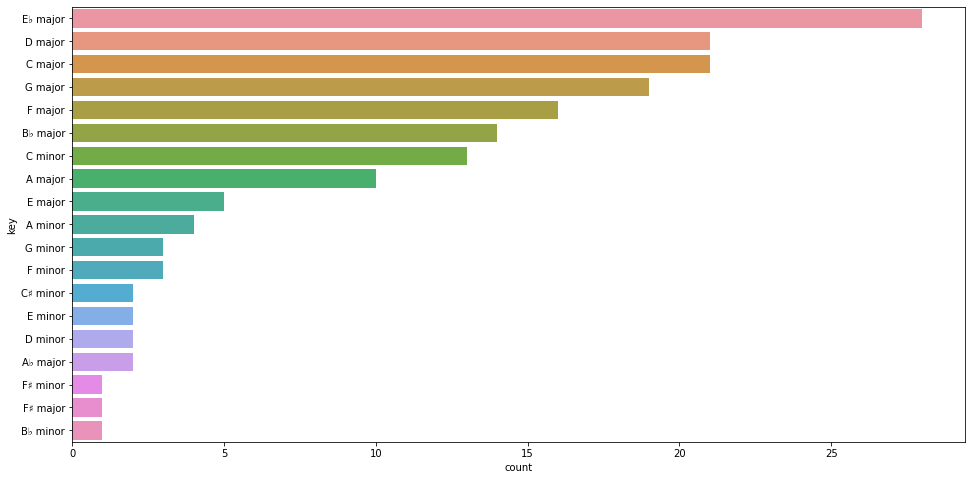

In [21]:
plt.figure(figsize=(16,8))
sns.countplot(y=df['key'], data=df, order = df['key'].value_counts().index)

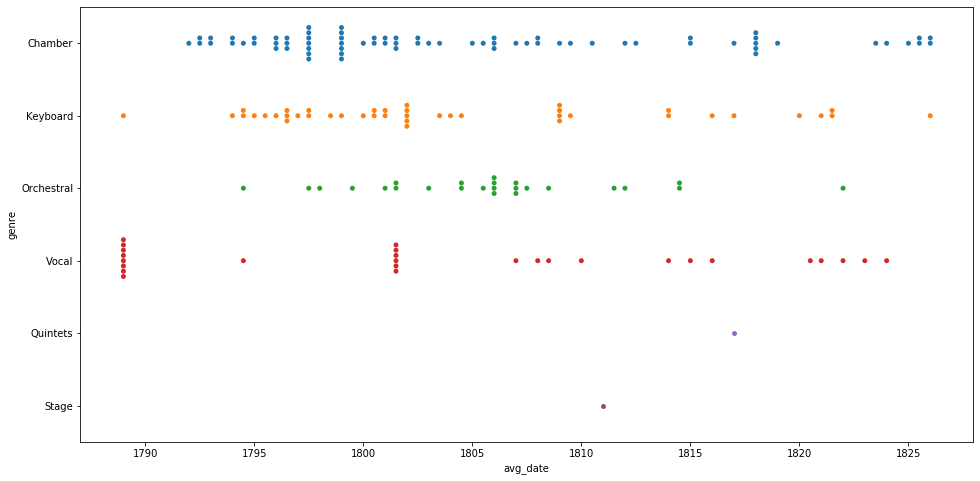

In [22]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['avg_date'],y=df['genre'])

In [23]:
# Top 1: E♭ major'
df.loc[df['key'] == 'E♭ major']

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
1,001/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,,major,1792,1793,1792.5
8,003,String Trio,E♭ major,1794,vn va vc,Chamber,see also Op.64,major,1794,1794,1794.0
9,004,String Quintet,E♭ major,1795,2vn 2va vc,Chamber,based on Op.103; see also Op.63,major,1795,1795,1795.0
14,007,Piano Sonata No.4 ('Grand Sonata'),E♭ major,1796-97,pf,Keyboard,,major,1796,1797,1796.5
28,012/3,Violin Sonata No.3,E♭ major,1797-98,vn pf,Chamber,,major,1797,1798,1797.5
34,016,Quintet in E-flat major,E♭ major,1796-97,ob cl bn hn pf,Chamber,arr for vn va vc pf as Op.16a,major,1796,1797,1796.5
35,016a,Quintet in E-flat major,E♭ major,1796-97,vn va vc pf,Chamber,arr of Op.16,major,1796,1797,1796.5
45,020,Septet,E♭ major,1799,cl bn hn vn va vc db,Chamber,,major,1799,1799,1799.0
53,027/1,Piano Sonata No.13 ('Quasi una fantasia'),E♭ major,1800-01,pf,Keyboard,,major,1800,1801,1800.5
64,031/3,Piano Sonata No.18 ('Hunt'),E♭ major,1802,pf,Keyboard,,major,1802,1802,1802.0


In [24]:
# Top 2: C major'
df.loc[df['key'] == 'C major']

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
7,002/3,Piano Sonata No.3,C major,1794-95,pf,Keyboard,,major,1794,1795,1794.5
33,015,Piano Concerto No.1,C major,1795-1800,pf orch,Orchestral,,major,1795,1800,1797.5
46,021,Symphony No.1,C major,1799-1800,orch,Orchestral,,major,1799,1800,1799.5
56,029,String Quintet in C major ('Storm'),C major,1801,2vn 2va vc,Chamber,,major,1801,1801,1801.0
73,039,Preludes (2) ('par tous les 12 tons majeurs'),C major,1789,pf/org,Keyboard,,major,1789,1789,1789.0
86,048/4,"Die Ehre Gottes aus der Natur (""Die Himmel rüh...",C major,1801-02,v pf,Vocal,,major,1801,1802,1801.5
87,048/5,"Gottes Macht und Vorsehung (""Gott ist mein Lei...",C major,1801-02,v pf,Vocal,,major,1801,1802,1801.5
103,053,"Piano Sonata No.21 (""Waldstein"")",C major,1803-04,pf,Keyboard,,major,1803,1804,1803.5
106,056,Triple Concerto,C major,1804-05,vn vc pf orch,Orchestral,,major,1804,1805,1804.5
113,059/3,String Quartet No.9,C major,1806,2vn va vc,Chamber,,major,1806,1806,1806.0


In [25]:
# Top 3: D major'
df.loc[df['key'] == 'D major']

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
13,006,Sonata for Piano Four Hands in D major,D major,1796-97,pf4h,Keyboard,,major,1796,1797,1796.5
15,008,Serenade,D major,1796-97,vn va vc,Chamber,,major,1796,1797,1796.5
18,009/2,String Trio,D major,1797-98,vn va vc,Chamber,,major,1797,1798,1797.5
23,010/3,Piano Sonata No.7,D major,1797-98,pf,Keyboard,,major,1797,1798,1797.5
26,012/1,Violin Sonata No.1,D major,1797-98,vn pf,Chamber,,major,1797,1798,1797.5
40,018/3,String Quartet No.3,D major,1798-1800,2vn va vc,Chamber,,major,1798,1800,1799.0
50,025,Serenade,D major,1801,"For flute, violin, viola",Chamber,arr. for fl pf as Op.41,major,1801,1801,1801.0
55,028,Piano Sonata No.15 ('Pastoral'),D major,1801,pf,Keyboard,,major,1801,1801,1801.0
69,036,Symphony No.2,D major,1801-02,orch,Orchestral,also arr. for vn vc pf,major,1801,1802,1801.5
70,036,Symphony No.2,D major,1805,vn vc pf,Chamber,arr. of version for orch,major,1805,1805,1805.0


In [26]:
# Last 1: F♯ major'
df.loc[df['key'] == 'F♯ major']

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
145,078,Piano Sonata No.24 ('A Thérèse'),F♯ major,1809,pf,Keyboard,,major,1809,1809,1809.0


In [27]:
# Last 2: B♭ minor
df.loc[df["key"] == "B♭ minor"]

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
170,094,"An die Hoffnung (""Ob ein Gott sei?"")",B♭ minor,1813-15,v pf,Vocal,2nd setting; see Op.32,minor,1813,1815,1814.0


In [28]:
# Last 3: F♯ minor
df.loc[df['key'] == 'F♯ minor']

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
85,048/3,"Vom Tode (""Meine Lebenszeit verstreicht"")",F♯ minor,1801-02,v pf,Vocal,,minor,1801,1802,1801.5


https://en.wikipedia.org/wiki/Beethoven_and_C_minor
<br>
In the compositions of Ludwig van Beethoven, the key of C minor is commonly regarded as significant: works for which he chose this key are felt to be powerful and emotionally stormy.

In [29]:
df.loc[df['key'] =='C minor']

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
3,001/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104,minor,1792,1794,1793.0
19,009/3,String Trio,C minor,1797-98,vn va vc,Chamber,,minor,1797,1798,1797.5
21,010/1,Piano Sonata No.5,C minor,1795-97,pf,Keyboard,,minor,1795,1797,1796.0
29,013,Piano Sonata No.8 ('Pathétique'),C minor,1797-98,pf,Keyboard,,minor,1797,1798,1797.5
41,018/4,String Quartet No.4,C minor,1798-1800,2vn va vc,Chamber,,minor,1798,1800,1799.0
59,030/2,Violin Sonata No.7 ('Eroica'),C minor,1801-02,vn pf,Chamber,,minor,1801,1802,1801.5
71,037,Piano Concerto No.3,C minor,1800-03,pf orch,Orchestral,,minor,1800,1803,1801.5
117,062,Coriolan,C minor,1807,orch,Orchestral,,minor,1807,1807,1807.0
122,067,Symphony No.5,C minor,1804-08,orch,Orchestral,,minor,1804,1808,1806.0
147,080,Fantasia in C minor ('Choral Fantasia'),C minor,1808-09,ch pf orch,Vocal,,minor,1808,1809,1808.5


## Genre

In [30]:
df['genre'] = df['genre'].str.replace(' ','')
df['genre'] = df['genre'].str.replace('Chanber','Chamber')

In [31]:
df['genre'].unique()

array(['Chamber', 'Keyboard', 'Orchestral', 'Vocal', 'Quintets', 'Stage'],
      dtype=object)

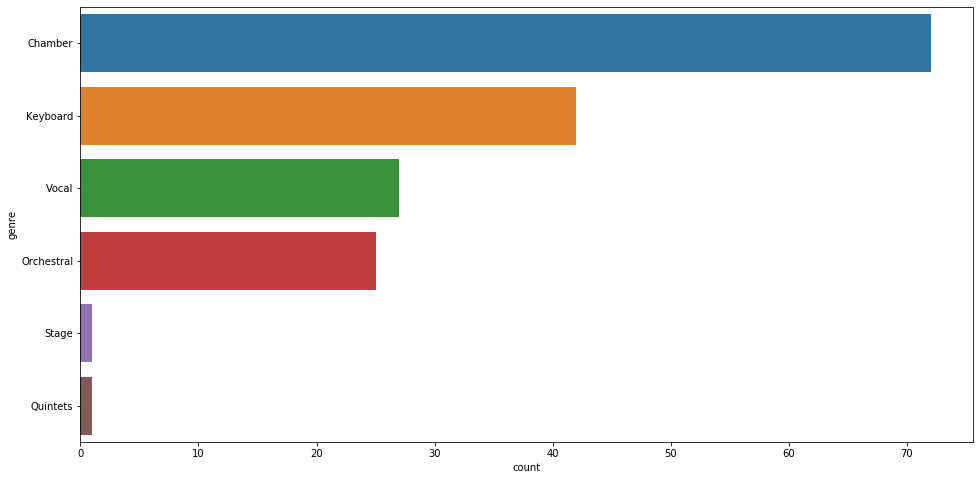

In [32]:
plt.figure(figsize=(16,8))
sns.countplot(y=df['genre'], data=df, order=df['genre'].value_counts().index)

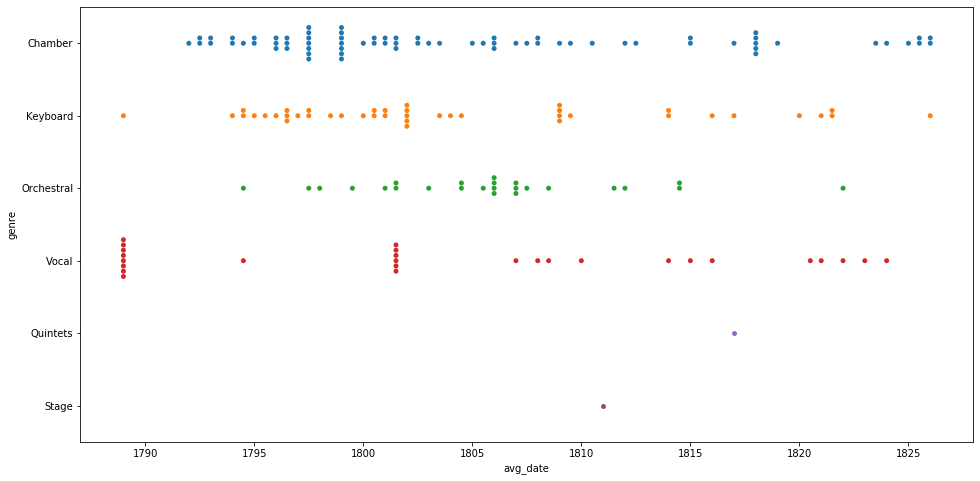

In [33]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['avg_date'],y=df['genre'])

In [34]:
df.loc[df['genre'] == 'Quintets']

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
188,104,String Quintet,C minor,1817,2vn 2va vc,Quintets,arrangement of Op.1/3,minor,1817,1817,1817.0


In [35]:
df.loc[df['genre'] == 'Stage']

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
242,117,"König Stephan (King Stephen), music to Kotzebu...",E♭ major,1811,vv ch orch,Stage,,major,1811,1811,1811.0


## Masterpiece: Piano Sonata

In [36]:
df.loc[df['title'].str.contains('Piano Sonata')]

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
5,002/1,Piano Sonata No.1,F minor,1793-95,pf,Keyboard,,minor,1793,1795,1794.0
6,002/2,Piano Sonata No.2,A major,1794-95,pf,Keyboard,,major,1794,1795,1794.5
7,002/3,Piano Sonata No.3,C major,1794-95,pf,Keyboard,,major,1794,1795,1794.5
14,007,Piano Sonata No.4 ('Grand Sonata'),E♭ major,1796-97,pf,Keyboard,,major,1796,1797,1796.5
21,010/1,Piano Sonata No.5,C minor,1795-97,pf,Keyboard,,minor,1795,1797,1796.0
22,010/2,Piano Sonata No.6,F major,1796-97,pf,Keyboard,,major,1796,1797,1796.5
23,010/3,Piano Sonata No.7,D major,1797-98,pf,Keyboard,,major,1797,1798,1797.5
29,013,Piano Sonata No.8 ('Pathétique'),C minor,1797-98,pf,Keyboard,,minor,1797,1798,1797.5
31,014/1,Piano Sonata No.9,E major,1798-99,pf,Keyboard,,major,1798,1799,1798.5
32,014/2,Piano Sonata No.10,G major,1799,pf,Keyboard,,major,1799,1799,1799.0


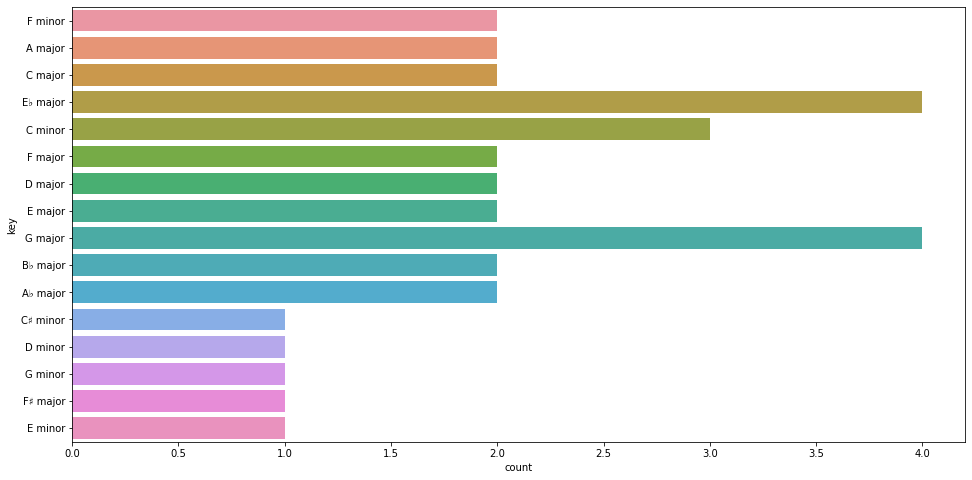

In [37]:
plt.figure(figsize=(16,8))
sns.countplot(y = df['key'][df['title'].str.contains('Piano Sonata')])

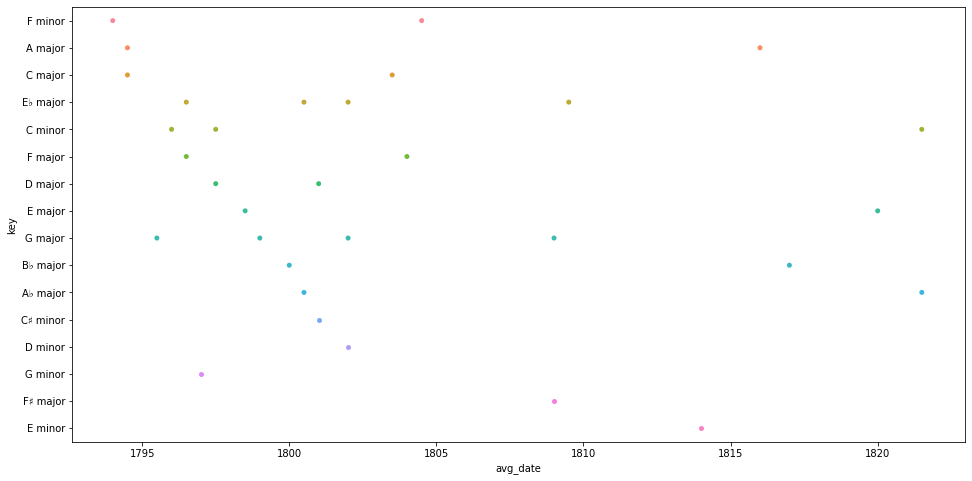

In [38]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['avg_date'],y=df['key'][df['title'].str.contains('Piano Sonata')])

## Masterpiece: Piano Trio

In [39]:
df.loc[df['title'].str.contains('Piano Trio')]

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
1,001/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,,major,1792,1793,1792.5
2,001/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,,major,1792,1794,1793.0
3,001/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104,minor,1792,1794,1793.0
126,070/1,Piano Trio ('Ghost'),D major,1808,vn vc pf,Chamber,,major,1808,1808,1808.0
127,070/2,Piano Trio,E♭ major,1808,vn vc pf,Chamber,,major,1808,1808,1808.0
173,097,"Piano Trio(""Archduke"")",B♭ major,1810-15,vn va vc,Chamber,,major,1810,1815,1812.5


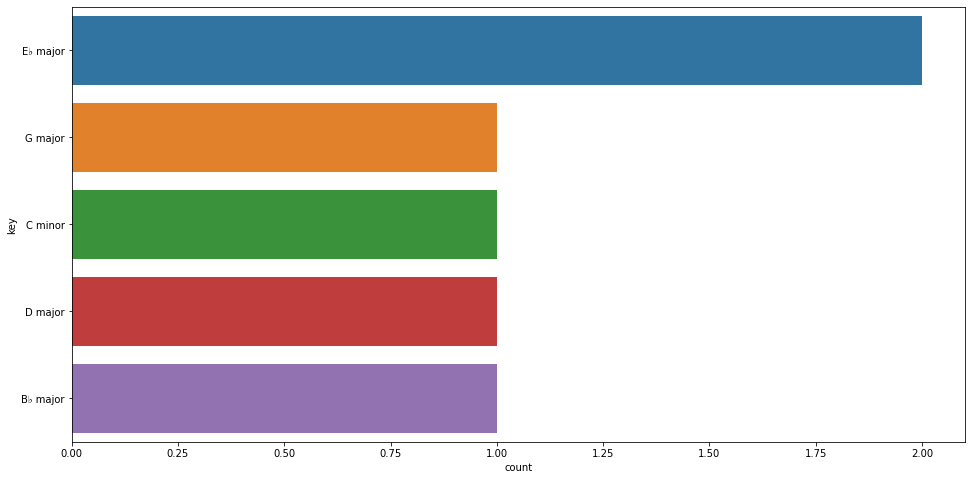

In [40]:
plt.figure(figsize=(16,8))
sns.countplot(y = df['key'][df['title'].str.contains('Piano Trio')])

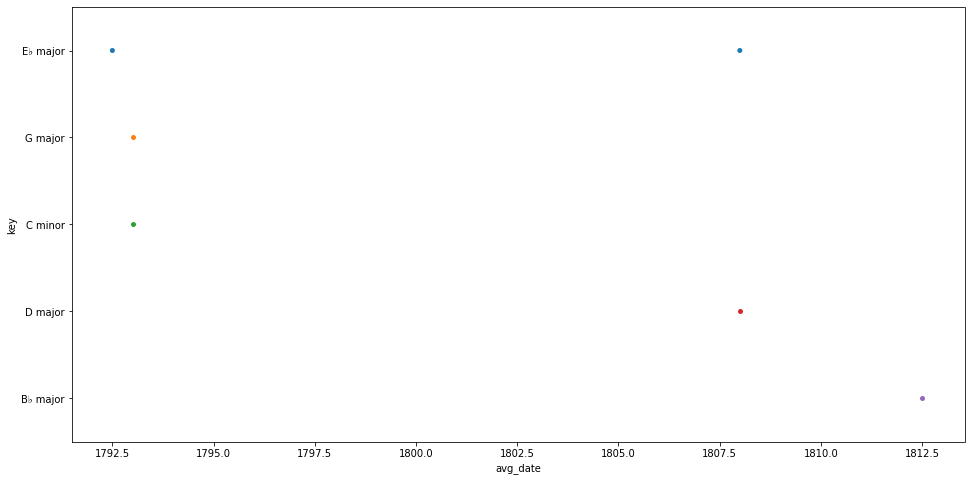

In [41]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['avg_date'],y=df['key'][df['title'].str.contains('Piano Trio')])

## Masterpiece: String Quartet

In [42]:
df.loc[df['title'].str.contains('String Quartet')]

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
38,018/1,String Quartet No.1,F major,1798-1800,2vn va vc,Chamber,,major,1798,1800,1799.0
39,018/2,String Quartet No.2,G major,1798-1800,2vn va vc,Chamber,,major,1798,1800,1799.0
40,018/3,String Quartet No.3,D major,1798-1800,2vn va vc,Chamber,,major,1798,1800,1799.0
41,018/4,String Quartet No.4,C minor,1798-1800,2vn va vc,Chamber,,minor,1798,1800,1799.0
42,018/5,String Quartet No.5,A major,1798-1800,2vn va vc,Chamber,,major,1798,1800,1799.0
43,018/6,String Quartet No.6,B♭ major,1798-1800,2vn va vc,Chamber,,major,1798,1800,1799.0
111,059/1,String Quartet No.7,F major,1806,2vn va vc,Chamber,,major,1806,1806,1806.0
112,059/2,String Quartet No.8,E minor,1806,2vn va vc,Chamber,,minor,1806,1806,1806.0
113,059/3,String Quartet No.9,C major,1806,2vn va vc,Chamber,,major,1806,1806,1806.0
135,074,String Quartet No.10 ('Harp'),E♭ major,1809,2vn va vc,Chamber,,major,1809,1809,1809.0


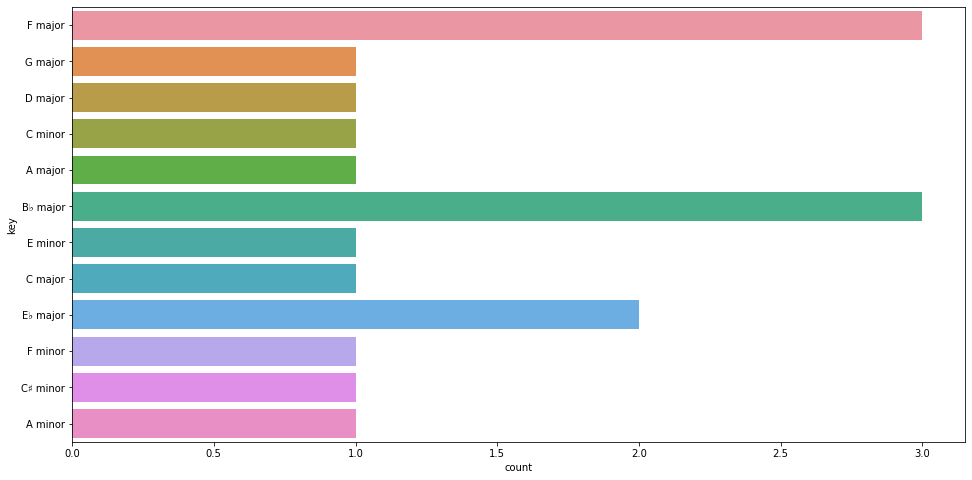

In [43]:
plt.figure(figsize=(16,8))
sns.countplot(y = df['key'][df['title'].str.contains('String Quartet')])

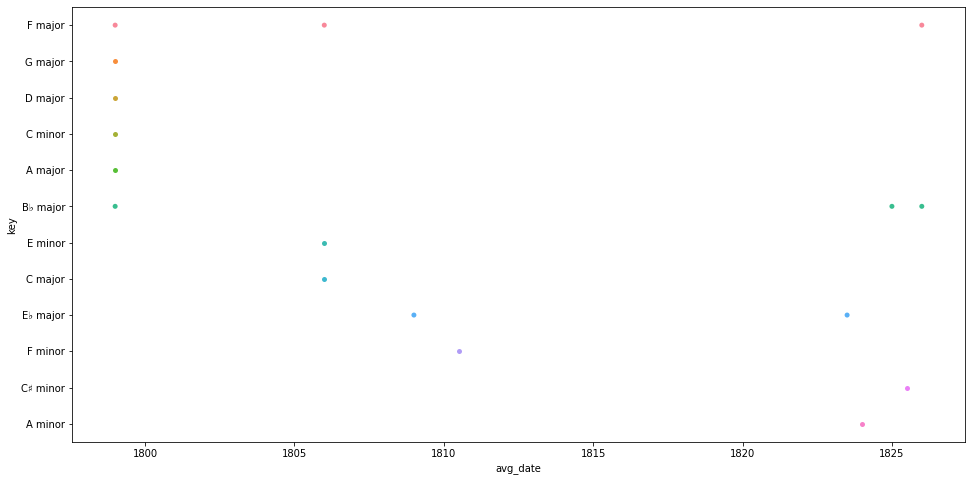

In [44]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['avg_date'],y=df['key'][df['title'].str.contains('String Quartet')])

## Masterpiece: Symphony

In [45]:
df.loc[df['title'].str.contains('Symphony')]

,op.,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
46,021,Symphony No.1,C major,1799-1800,orch,Orchestral,,major,1799,1800,1799.5
69,036,Symphony No.2,D major,1801-02,orch,Orchestral,also arr. for vn vc pf,major,1801,1802,1801.5
70,036,Symphony No.2,D major,1805,vn vc pf,Chamber,arr. of version for orch,major,1805,1805,1805.0
105,055,Symphony No.3 ('Eroica'),E♭ major,1803,orch,Orchestral,,major,1803,1803,1803.0
114,060,Symphony No.4,B♭ major,1806,orch,Orchestral,,major,1806,1806,1806.0
122,067,Symphony No.5,C minor,1804-08,orch,Orchestral,,minor,1804,1808,1806.0
123,068,Symphony No.6,F major,1807-08,orch,Orchestral,,major,1807,1808,1807.5
168,092,Symphony No.7,A major,1811-12,orch,Orchestral,,major,1811,1812,1811.5
169,093,Symphony No.8,F major,1812,orch,Orchestral,,major,1812,1812,1812.0
252,125,Symphony No.9,D minor,1817-24,sop alt ten bass ch,Vocal,,minor,1817,1824,1820.5
